In [3]:
import torch
import models_jw
from utils import *
from tqdm import tqdm
import numpy as np

device = "cuda"

In [4]:
from configs import paramsuper, getters
import torch
args = paramsuper.ICIFARHashResNet18()

torch.manual_seed(args.seed)
np.random.seed(0)

use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
training_period = 20000

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = getters.get_dataset(args.dataset, training_period, args.batch_size, True, kwargs)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
net = models_jw.HashResNet18(10).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01)
TASKS_NUM = 5
for time in tqdm(range(TASKS_NUM*training_period)):
    X, y = train_loader.get_data()
    X, y = X.to(device), y.to(device)        
    z = torch.zeros(10)
    z[time // args.period] = 1
    y_hat, _, _ = net(X, z)
    optimizer.zero_grad()
    loss = hinge_loss(y_hat, y, 1)
    loss.backward()
    optimizer.step()

100%|██████████| 100000/100000 [1:23:27<00:00, 19.97it/s]


In [6]:
torch.save(net.state_dict(), "5_tasks_hunge10.pth")

In [3]:
torch.manual_seed(1)
np.random.seed(0)

net2 = models_jw.HashResNet18(10).to(device)
net2.load_state_dict(torch.load("5_tasks_hunge10.pth"))

<All keys matched successfully>

In [4]:
# EVALUATE WITH task_num

test_loader = getters.get_dataset(args.dataset, 1, args.test_batch_size, False, kwargs)
tasks_num = 10
accs =  {i: 0 for i in range(tasks_num)}
for time in tqdm(range(tasks_num)):
    X, y = test_loader.get_data()
    X, y = X.to(device), y.to(device)        
    z = torch.zeros(10)
    z[time] = 1
    y_hat, _, _ = net2(X, z)
    accs[time] = accs[time] + (y_hat.min(1).indices==y).sum().item()
accs

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [00:01<00:00,  9.09it/s]


{0: 648, 1: 517, 2: 693, 3: 615, 4: 700, 5: 98, 6: 118, 7: 80, 8: 115, 9: 104}

In [5]:
# EVALUATE WITHOUT task_num

num_test = 10
test_loader = getters.get_dataset(args.dataset, 1, 5, False, kwargs)
accs_test =  {i: 0 for i in range(num_test)}

zzz = {}
for time in tqdm(range(num_test)):
    X, y = test_loader.get_data()
    X, y = X.to(device), y.to(device)        
    y_hat, z, losses = net2(X)
    zzz[time] = z 
    #accs[time] = accs[time] + (y_hat.min(1).indices==y).sum().item()
    accs_test[time] = accs_test[time] + (torch.tensor(y_hat) == y.to("cpu")).sum().item()
    

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (576x10 and 5x1)

In [9]:
z

[tensor([0.8921, 0.0294, 0.0154, 0.0194, 0.0126, 0.0077, 0.0058, 0.0049, 0.0056,
         0.0071], device='cuda:0'),
 tensor([0.9374, 0.0100, 0.0078, 0.0109, 0.0102, 0.0051, 0.0046, 0.0042, 0.0046,
         0.0053], device='cuda:0'),
 tensor([0.7998, 0.0917, 0.0158, 0.0265, 0.0183, 0.0111, 0.0090, 0.0071, 0.0102,
         0.0105], device='cuda:0'),
 tensor([0.6766, 0.1436, 0.0246, 0.0532, 0.0400, 0.0147, 0.0118, 0.0093, 0.0125,
         0.0136], device='cuda:0'),
 tensor([0.5534, 0.2665, 0.0398, 0.0350, 0.0409, 0.0147, 0.0136, 0.0105, 0.0114,
         0.0143], device='cuda:0')]

In [7]:
accs_test

{0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1}

In [10]:
torch.tensor(y_hat) 

tensor([8, 8, 8, 8, 8])

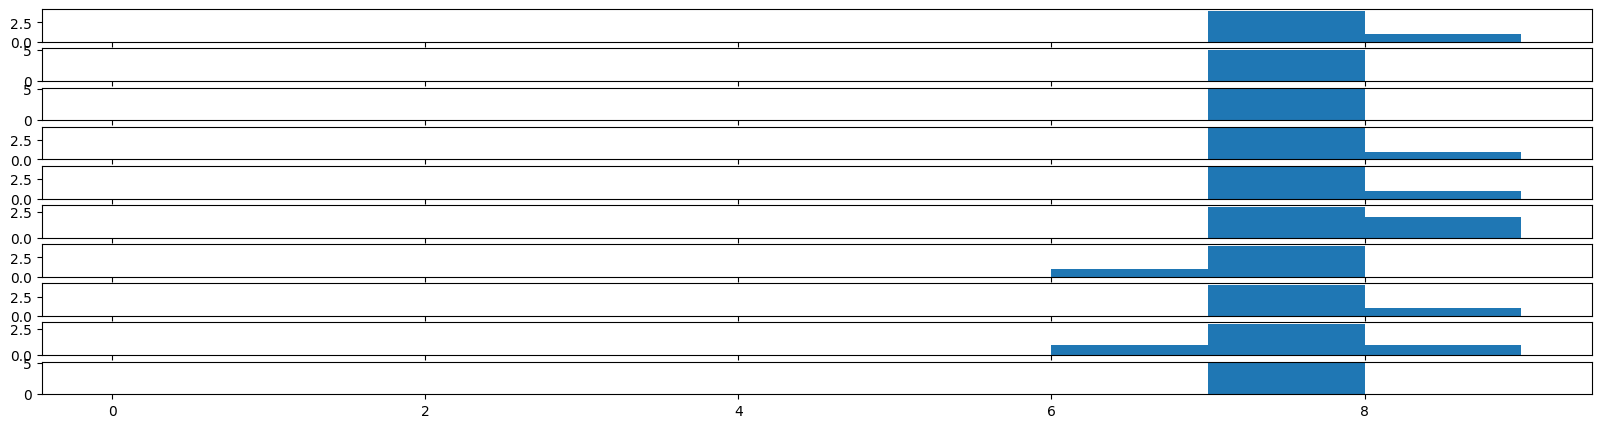

In [8]:

import matplotlib.pyplot as plt
fig, axs = plt.subplots(10, figsize=(20,5))
for i in range(10):
    axs[i].hist(torch.stack(zzz[i]).min(1).indices.cpu().numpy(), bins=range(10))

In [12]:
zzz

{0: [tensor([ 1.3033,  4.3467, -0.6621, -0.7403, -0.6441, -0.4234, -0.9318, -0.5678,
           0.2038, -0.8844], device='cuda:0'),
  tensor([ 0.9704,  4.7921, -0.7192, -0.6246, -0.7366, -0.2269, -0.6769, -0.3177,
          -0.5625, -0.8981], device='cuda:0'),
  tensor([ 4.2421,  1.9055, -0.7806, -0.7036, -0.6371, -0.4943, -0.8196, -0.3552,
          -0.6010, -0.7563], device='cuda:0'),
  tensor([ 0.6117,  4.4417, -0.7328, -0.7208, -0.4382,  0.1496, -0.7525, -0.1378,
          -0.8089, -0.6122], device='cuda:0'),
  tensor([ 2.4357,  3.9742, -0.7581, -0.7301, -0.6253, -0.5732, -0.8430, -0.5383,
          -0.5264, -0.8155], device='cuda:0')],
 1: [tensor([ 0.4247,  4.4681, -0.7333, -0.3081, -0.4378, -0.3659, -0.3816, -0.4283,
          -0.4997, -0.7382], device='cuda:0'),
  tensor([ 2.6166,  3.2815, -0.9868, -0.6370, -0.4151, -0.8107, -0.8876, -0.4944,
           0.0107, -0.6772], device='cuda:0'),
  tensor([ 0.0691,  5.1877, -0.5070, -0.5021, -0.5395, -0.4053, -0.8805, -0.2722,
        

In [90]:
# import matplotlib.pyplot as plt #koń, pies, samolot
# fig, axs = plt.subplots(10,figsize=(5,40))
# for idx, i in enumerate(X[:10]):
#     axs[idx].imshow(i.permute(1,2,0).numpy())

In [89]:
accs

{0: 2, 1: 1, 2: 0}

In [88]:
zzz[1]

[tensor([-245.9485,   41.0720,  123.7339,  -20.3982,  -13.6119,    2.4594,
           23.8586,   11.9880,   15.3942,  -23.4679], device='cuda:0'),
 tensor([-220.8584,    2.0477,  138.7914,  -26.9805,  -22.2933,   -4.6194,
           26.4026,   11.6240,    6.5466,   -9.4133], device='cuda:0'),
 tensor([-213.2227,   20.5275,  144.8369,   -5.1570,   14.7023,   23.5151,
           33.5397,   13.4607,   30.3790,    3.5353], device='cuda:0'),
 tensor([-213.2119,   50.4990,  157.6112,   13.9355,   -3.1974,    4.1927,
           -2.4120,   44.0033,    9.7511,  -11.4271], device='cuda:0'),
 tensor([-215.6507,   42.1164,  148.8064,   -7.6765,  -30.4505,   -3.6351,
            5.5471,    7.2766,    2.2397,  -24.2976], device='cuda:0')]

In [7]:
fig, axs = plt.subplots(3)
for i in range(3):
    axs[i].hist(torch.stack(zzz[i]).min(1).indices.cpu().numpy())

NameError: name 'plt' is not defined

In [ ]:
# PROBLEM 5 samples = 1 minute

In [2]:

m = models_jw.HashResNet18(10)

In [3]:
m.to("cuda")

HashResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (layer1): ModuleList(
    (0-1): 2 x HashBasicBlock(
      (conv1): HashConv2d()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv2): HashConv2d()
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (shortcut): ModuleList()
    )
  )
  (layer2): ModuleList(
    (0): HashBasicBlock(
      (conv1): HashConv2d()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv2): HashConv2d()
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (shortcut): ModuleList(
        (0): HashConv2d()
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    

In [10]:
img = torch.rand((20,3,32,32), device="cuda")

12.0

In [12]:
m(img)#, torch.ones(10, device="cuda", requires_grad=True))

([tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(9)],
 [tensor([ 0.3867,  1.7251, -2.1452,  1.6405,  1.8650, -0.2516, -0.1177, -0.6333,
          -0.3887,  0.8633], device='cuda:0'),
  tensor([-0.0706,  0.6241, -0.7360,  1.6453,  2.5672, -1.7667,  0.4365, -1.1464,
           0.0431,  0.3689], device='cuda:0'),
  tensor([ 0.1246,  1.6834, -1.1506,  1.3375,  2.3137, -1.2102, -0.0281, -0.8342,
          -0.2544,  1.0565], device='cuda:0'),
  tensor([ 0.1914,  2.1499, -0.2643,  1.0539,  1.9850, -1.1633, -0.0533, -0.1179,
           0.6964,  0.6024], device='cuda:0'),
  tensor([ 0.6807,  1.5459, -1.5954,  0.9104,  2.4229, -1.9098, -0.8851, -0.3445,
          -0.3381,  0.7602], device='cuda:0'),
  tensor([-0.5505,  1.9644, -1.0665,  1.6075,  2.0348, -0.4183, -0.2435, -0.8585,
           0

In [16]:
y_hat = preds[-gt]
proper_pred = torch.gather(y_hat, 1, gt.view(-1, 1)).squeeze()

In [38]:
y_hat = torch.tensor([[1,1.1,3,4], [5,6,-7,1]])
gt = torch.tensor([0,3])

In [39]:
hinge_loss(y_hat, gt)

tensor(9.9000)

In [28]:
mask = torch.ones(y_hat.size(), dtype=torch.bool)
rows = torch.arange(y_hat.size(0))
mask[rows, gt] = False
y_hat_wrongs = y_hat[mask].reshape(y_hat.size(0), y_hat.size(1) - 1)
torch.clamp(proper_pred - y_hat_wrongs + 1, min=0).sum()





tensor(0.)

In [26]:
new_tensor

tensor([[2, 3, 4],
        [5, 6, 7]])

In [11]:
y_hat - proper_pred

tensor([[ 0.0000, 16.9066,  0.9249,  0.9669,  1.0736,  1.0238,  7.9881,  1.2362,
         -0.1323,  1.1910]])

In [21]:
mask = torch.ones(tensor.size(1), dtype=torch.bool)
mask[indices_to_delete] = False

tensor([-0.3650, 16.5416,  0.5599,  0.6019,  0.7086,  0.6588,  7.6231,  0.8712,
        -0.4973,  0.8260])

In [18]:
torch.clamp(proper_pred - y_hat + 1, min=0)

tensor([[1.0000, 0.0000, 0.0751, 0.0331, 0.0000, 0.0000, 0.0000, 0.0000, 1.1323,
         0.0000]])

In [3]:
preds = -torch.tensor([[  0.3650, -16.5416,  -0.5599,  -0.6019,  -0.7086,  -0.6588,  -7.6231,
         -0.8712,   0.4973,  -0.8260]])
gt = torch.tensor([0])

In [4]:
square_square_loss(preds, gt)

KeyboardInterrupt: 

In [88]:
hinge_loss(preds, gt)

tensor(0.)

square_square_loss(preds, gt)

In [46]:
torch.arange(3)

tensor([0, 1, 2])

In [ ]:
import torch
import torch.optim as optim


def inference(x, net, C=3):
    min_value = float('inf')
    min_x = None
    min_y = None

    def energy(z, y, x, net):
        return net(x, z)[y]

    def minimize_with_respect_to_z(y, x, net, lr=0.01, num_steps=1000):
        z = torch.ones(C)/C
        
        optimizer = optim.SGD([z], lr=lr)
        
        for _ in range(num_steps):
            optimizer.zero_grad()
            loss = energy(z, y, x, net)
            loss.backward()
            optimizer.step()
        return z.detach(), energy(z.detach(), y, x, net).detach()

    for y in torch.arange(C):
        x_min, e_min = minimize_with_respect_to_z(y, x, net)
        if e_min < min_value:
            min_value = e_min
            min_x = x_min
            min_y = y
    
    print(f"Global minimum found at x = {min_x.item()}, y = {min_y.item()}, with E(x, y) = {min_value.item()}")